In [ ]:
import os
import json
from typing import List
import math
from glob import glob

from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
from pandas import json_normalize
import pandas as pd
import re
import warnings

import albumentations as A

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

# !pip freeze | grep albumentations
# !pip install albumentations==0.4.6 -> albumentations버전을 해당 버전으로 맞춰줘야함
from albumentations.pytorch.transforms import ToTensorV2

from matplotlib import pyplot as plt
warnings.filterwarnings(action='ignore')


rootfolder = '/content/drive/My Drive/dacon - 위성 객체 인식/위성객체폴더'
DIR_TRAIN = os.path.join(rootfolder,'train/images')


In [1]:
!pip freeze | grep torch

torch==1.6.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.7.0+cu101


# geo to coco 변환 부분

In [ ]:
# 메타 데이터 정의

NIA_CLASSES = ['background', '소형 선박', '대형 선박', '민간 항공기', '군용 항공기', '소형 승용차', '버스', '트럭', '기차', '크레인', '다리', '정유탱크',
               '댐', '운동경기장', '헬리패드', '원형 교차로']
CLASS_NAMES_EN = ('background', 'small ship', 'large ship', 'civilian aircraft', 'military aircraft', 'small car', 'bus', 'truck', 'train',
        'crane', 'bridge', 'oil tank', 'dam', 'athletic field', 'helipad', 'roundabout')


In [ ]:
# xywha 좌표계를 x,y로 변환하는 함수 정의
def convert_xywha_to_8coords(xywha, is_clockwise=False):
    x, y, w, h, a = xywha
    angle = a if is_clockwise else -a

    lt_x, lt_y = -w / 2, -h / 2
    rt_x, rt_y = w / 2, - h/ 2
    rb_x, rb_y = w / 2, h / 2
    lb_x, lb_y = - w / 2, h / 2

    lt_x_ = lt_x * math.cos(angle) - lt_y * math.sin(angle) + x
    lt_y_ = lt_x * math.sin(angle) + lt_y * math.cos(angle) + y
    rt_x_ = rt_x * math.cos(angle) - rt_y * math.sin(angle) + x
    rt_y_ = rt_x * math.sin(angle) + rt_y * math.cos(angle) + y
    lb_x_ = lb_x * math.cos(angle) - lb_y * math.sin(angle) + x
    lb_y_ = lb_x * math.sin(angle) + lb_y * math.cos(angle) + y
    rb_x_ = rb_x * math.cos(angle) - rb_y * math.sin(angle) + x
    rb_y_ = rb_x * math.sin(angle) + rb_y * math.cos(angle) + y

    return [lt_x_, lt_y_, rt_x_, rt_y_, rb_x_, rb_y_, lb_x_, lb_y_]


# x,y좌표계를 coco 데이터 포멧으로 변환하는 함수
def convert_8coords_to_4coords(coords):
    x_coords = coords[0::2]
    y_coords = coords[1::2]
    
    xmin = min(x_coords)
    ymin = min(y_coords)

    xmax = max(x_coords)
    ymax = max(y_coords)

    w = xmax-xmin
    h = ymax-ymin

    return [xmin, ymin, w, h]

# json 파일에서 필요한 정보를 불러오는 함수

def convert_labels_to_objects(coords, class_ids, class_names, image_ids, difficult=0, is_clockwise=False):
    objs = list()
    inst_count = 1

    for polygons, cls_id, cls_name, img_id in tqdm(zip(coords, class_ids, class_names, image_ids), desc="converting labels to objects"):
        xmin, ymin, w, h = convert_8coords_to_4coords(polygons)
        single_obj = {}
        single_obj['difficult'] = difficult
        single_obj['area'] = w*h
        if cls_name in CLASS_NAMES_EN:
            single_obj['category_id'] = CLASS_NAMES_EN.index(cls_name)
        else:
            continue
        single_obj['segmentation'] = [[int(p) for p in polygons]]
        single_obj['iscrowd'] = 0
        single_obj['bbox'] = (xmin, ymin, w, h)
        single_obj['image_id'] = img_id
        single_obj['id'] = inst_count
        inst_count += 1
        objs.append(single_obj)

    print('objects', len(objs))
    return objs

# geojson파일을 불러오는 함수
def load_geojsons(filepath):
    """ Gets label data from a geojson label file

    :param (str) filename: file path to a geojson label file
    :return: (numpy.ndarray, numpy.ndarray ,numpy.ndarray) coords, chips, and classes corresponding to
            the coordinates, image names, and class codes for each ground truth.
    """
    jsons = glob(os.path.join(filepath, '*.json'))
    features = []
    for json_path in tqdm(jsons, desc='loading geojson files'):
        with open(json_path) as f:
            data_dict = json.load(f)
        features += data_dict['features']

    obj_coords = list()
    image_ids = list()
    class_indices = list()
    class_names = list()

    for feature in tqdm(features, desc='extracting features'):
        properties = feature['properties']
        image_ids.append(properties['image_id'].replace('PS4', 'PS3')[:-4]+'.png')
        obj_coords.append([float(num) for num in properties['object_imcoords'].split(",")])
        class_indices.append(properties['type_id'])
        class_names.append(properties['type_name'])

    return image_ids, obj_coords, class_indices, class_names

# coco변환 함수

def geojson2coco(imageroot: str, geojsonpath: str, destfile, difficult='-1'):
    # set difficult to filter '2', '1', or do not filter, set '-1'

    data_dict = {}
    data_dict['images'] = []
    data_dict['categories'] = []
    data_dict['annotations'] = []
    for idex, name in enumerate(CLASS_NAMES_EN):
        single_cat = {'id': idex + 1, 'name': name, 'supercategory': name}
        data_dict['categories'].append(single_cat)

    inst_count = 1
    image_id = 1
    with open(destfile, 'w') as f_out:
      
        img_files, obj_coords, cls_ids, class_names = load_geojsons(geojsonpath)
        img_id_map= {img_file:i+1 for i, img_file in enumerate(list(set(img_files)))}
        image_ids = [img_id_map[img_file] for img_file in img_files]

        objs = convert_labels_to_objects(obj_coords, cls_ids, class_names, image_ids, difficult=difficult, is_clockwise=False)
        data_dict['annotations'].extend(objs)

        for imgfile in tqdm(img_id_map, desc='saving img info'):
            imagepath = os.path.join(imageroot, imgfile)
            img_id = img_id_map[imgfile]
            img = cv2.imread(imagepath)
            height, width, c = img.shape
            single_image = {}
            single_image['file_name'] = imgfile
            single_image['id'] = img_id
            single_image['width'] = width
            single_image['height'] = height
            single_image['image_name'] = imgfile
            data_dict['images'].append(single_image)

        json.dump(data_dict, f_out)

In [ ]:
# 정제하는 과정에서 bbox값이 5개가 들어가는 경우가 있음
rootfolder = '/content/drive/My Drive/dacon - 위성 객체 인식/위성객체폴더'

geojson2coco(imageroot=os.path.join(rootfolder, 'train/images'),
                 geojsonpath=os.path.join(rootfolder, 'train/json'),
                 destfile=os.path.join(rootfolder, 'coco_format/traincoco.json'))
    
# geojson2coco(imageroot=os.path.join(rootfolder, 'val/images'),
#                  geojsonpath=os.path.join(rootfolder, 'val/json'),
#                  destfile=os.path.join(rootfolder, 'val/valcoco.json'))

extracting features: 100%|██████████| 131436/131436 [00:00<00:00, 159363.61it/s]
converting labels to objects: 131436it [00:01, 106574.16it/s]
saving img info:   0%|          | 0/800 [00:00<?, ?it/s]

objects 130583


saving img info: 100%|██████████| 800/800 [25:03<00:00,  1.88s/it]


# 저장한 Json 파일 로드

In [ ]:
with open(os.path.join(rootfolder,'coco_format/traincoco.json')) as js_file:

  json_data = json.load(js_file)

coco_df = json_normalize(json_data['annotations'])

# 이미지 이름(파일 이름) 불러오는 부분
image_id_df = pd.DataFrame()
file_name = []
id_ls = []
for file_nm in json_data['images']:
  file_name.append(file_nm.get('file_name'))
  id_ls.append(file_nm.get('id'))

image_id_df['image_id'] = id_ls
image_id_df['image_name'] = file_name

coco_df = pd.merge(coco_df,image_id_df, on = 'image_id',how = 'left')

# # 데이터 저장
# coco_df.to_csv(f'{rootfolder}/coco_format/cocodata_format.csv',index = False)

# coco_df = pd.read_csv(os.path.join(rootfolder, 'coco_format/cocodata_format.csv'))

In [ ]:
coco_df.head()

,difficult,area,category_id,segmentation,iscrowd,bbox,image_id,id,image_name
0,-1,545.428383,6,"[[126, 6, 132, 12, 115, 29, 109, 23]]",0,"[109.15200835404708, 6.042306661237552, 23.237...",534,1,OBJ04712_PS3_K3A_NIA0313.png
1,-1,235.320839,6,"[[144, 35, 149, 38, 140, 52, 135, 48]]",0,"[135.46203918752542, 35.25559525093445, 14.002...",534,2,OBJ04712_PS3_K3A_NIA0313.png
2,-1,475.416380,6,"[[188, 22, 193, 18, 209, 37, 204, 41]]",0,"[188.6945995355065, 18.732157863096617, 20.798...",534,3,OBJ04712_PS3_K3A_NIA0313.png
3,-1,407.770412,6,"[[208, 6, 213, 2, 227, 19, 223, 23]]",0,"[208.48511596999444, 2.511602312589588, 19.281...",534,4,OBJ04712_PS3_K3A_NIA0313.png
4,-1,68.193931,5,"[[10, 125, 5, 125, 4, 114, 9, 114]]",0,"[4.268435351393462, 114.4759523679983, 6.22074...",534,5,OBJ04712_PS3_K3A_NIA0313.png


In [ ]:
# 학습할 데이터 형태로 추출
coco_df2 = coco_df[['image_name','segmentation','category_id','bbox']]

# coco dataset bbox 변환

In [ ]:
coco_df2['x'] = -1
coco_df2['y'] = -1
coco_df2['w'] = -1
coco_df2['h'] = -1

In [ ]:
# def string_to_list_convert(x):
#   ls = np.array(re.findall('([0-9]+[.]?[0-9]*)',x))

#   if len(ls) == 0:
#         ls = [-1, -1, -1, -1]
#   return ls

In [ ]:
coco_df2['bbox_len'] = coco_df2['bbox'].apply(lambda x: len(x))

coco_df3 = coco_df2[coco_df2['bbox_len'] == 4]

coco_df3[['x','y','w','h']] = np.stack(coco_df3['bbox'])

coco_df3['x'] = coco_df3['x'].astype(np.float)
coco_df3['y'] = coco_df3['y'].astype(np.float)
coco_df3['w'] = coco_df3['w'].astype(np.float)
coco_df3['h'] = coco_df3['h'].astype(np.float)

# coco_df3.drop(columns = ['bbox','bbox_len'],inplace = True)
coco_df3.drop(columns = ['bbox_len'],inplace = True)
# coco_df3.rename(columns = {'bbox2':'bbox'},inplace = True)

coco_df3[['height','width']] = [1024,1024]
coco_df4 = coco_df3[['image_name','width','height','category_id','x','y','w','h']]

In [ ]:
# # 각 image_id에 맞는 사진 파일명 불러오기
# file_name_df = pd.DataFrame()

# file_name_df['image_id'] = coco_df.sort_values('image_id')['image_id'].unique().tolist()
# file_name_df['image_id2'] = os.listdir(DIR_TRAIN)

# coco_df5 = pd.merge(coco_df4,file_name_df,on='image_id',how = 'left')

# coco_df5['image_id'] = coco_df5['image_id2']
# coco_df5.drop(columns = 'image_id2',inplace = True)

In [ ]:
coco_df4.rename(columns = {'image_name':'image_id'},inplace = True)

# train, validset 데이터 생성

In [ ]:
img_ids = coco_df4['image_id'].unique().tolist()
valid_ids = img_ids[int(-1*len(img_ids)*0.2):]
train_ids = img_ids[:int(-1*len(img_ids)*0.2)]

In [ ]:
coco_train = coco_df4[
                      coco_df4['image_id'].isin(train_ids)
                      ]
coco_valid = coco_df4[
                      coco_df4['image_id'].isin(valid_ids)
                      ]


In [ ]:
coco_train.head()

,image_id,width,height,category_id,x,y,w,h
0,OBJ03947_PS3_K3A_NIA0166.png,1024,1024,6,109.152008,6.042307,23.237749,23.471653
1,OBJ03947_PS3_K3A_NIA0166.png,1024,1024,6,135.462039,35.255595,14.002621,16.805486
2,OBJ03947_PS3_K3A_NIA0166.png,1024,1024,6,188.694600,18.732158,20.798985,22.857672
3,OBJ03947_PS3_K3A_NIA0166.png,1024,1024,6,208.485116,2.511602,19.281751,21.147997
4,OBJ03947_PS3_K3A_NIA0166.png,1024,1024,5,4.268435,114.475952,6.220747,10.962339


In [ ]:
coco_train['category_id'].nunique()

15

# 샘플로 Bbox 도식화 해보기

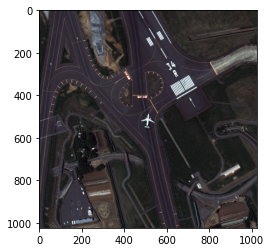

In [ ]:
img = cv2.imread(os.path.join(rootfolder,'train/images/OBJ03589_PS3_K3A_NIA0151.png') , cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.figure(figsize = (16,16)) #용량 문제로 주석 처리
plt.imshow(img) 

In [ ]:
sample_box = coco_train[coco_train['image_id'] == 'OBJ03589_PS3_K3A_NIA0151.png'][['x','y','w','h']].iloc[0].tolist()
sample_box2 = [sample_box[0],sample_box[1],sample_box[0] + sample_box[2],sample_box[1] + sample_box[3]]

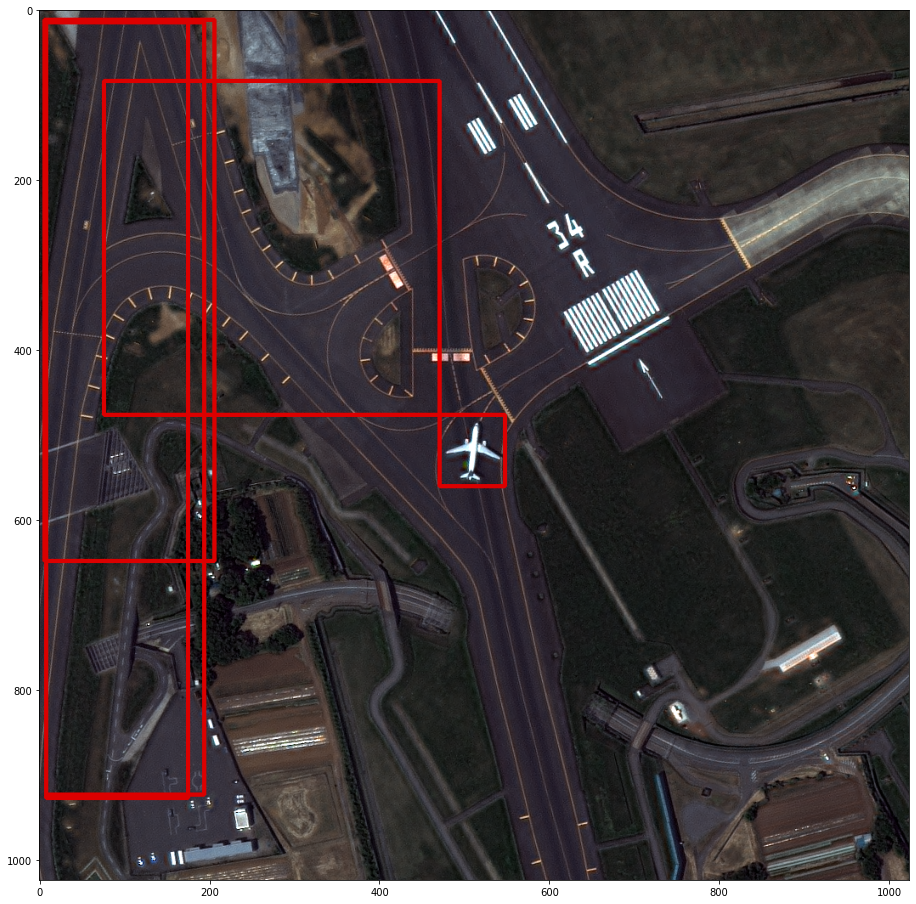

In [ ]:
cv2.rectangle(img,
              (int(sample_box2[0]), int(sample_box2[1])),
              (int(sample_box2[2]), int(sample_box2[3])),
              (220, 0, 0), 3)

plt.figure(figsize = (16,16))
plt.imshow(img)

# torch dataset

In [ ]:
# 에러나온 부분 해결하는 코드

# next(iter(train_data_loader))

# for i in range(0,500):
#   print(i)
#   image_id = img_ids[i]
#   records = coco_train[coco_train['image_id'] == image_id]

#   image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#   image /= 255.0

In [ ]:
# 이거 코드 뜯어보자
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    # dataloader에 필요한 값으로 정리가 됨
    def __getitem__(self, index: int):

        try:
          image_id = self.image_ids[index]
          records = self.df[self.df['image_id'] == image_id]

          image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
          image /= 255.0
          
          
          boxes = records[['x', 'y', 'w', 'h']].values
          boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
          boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
          
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
          area = torch.as_tensor(area, dtype=torch.float32)

          # there is only one class
          labels = torch.ones((records.shape[0],), dtype=torch.int64)
          
          # suppose all instances are not crowd
          iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
          
          target = {}
          target['boxes'] = boxes
          target['labels'] = labels
          # target['masks'] = None
          target['image_id'] = torch.tensor([index])
          target['area'] = area
          target['iscrowd'] = iscrowd

          if self.transforms:
              sample = {
                  'image': image,
                  'bboxes': target['boxes'],
                  'labels': labels
              }
              sample = self.transforms(**sample)
              image = sample['image']
              
              target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
              #target['boxes'] = target['boxes'].type(torch.float32)
          return image, target, image_id
        except:
          pass

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# 모델 생성

In [ ]:
# load a model; pre-trained on COCO -> 이미지넷으로 학습된 코코에서 faster rcnn 모델 불러옴
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes =   16 # 1 class (wheat) + background -> 밀과 배경을 구분하기 위해서 class + 1을 클래스 분류 값으로 넣어줌

# get number of input features for the classifier
# 이게 왜 필요한거지?
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
# 배치사이즈 튜플화?
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()

    self.image_ids = dataframe['image_id'].unique()
    self.df = dataframe
    self.image_dir = image_dir
    self.transforms = transforms

In [ ]:
# 이미지 파일 위치하는 경로
DIR_TRAIN = os.path.join(rootfolder,'train/images')

train_dataset = WheatDataset(coco_train, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(coco_valid, DIR_TRAIN, get_valid_transform())

In [ ]:
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

In [ ]:

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

# 샘플 학습

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
# 해당 과정을 거치는 이유
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


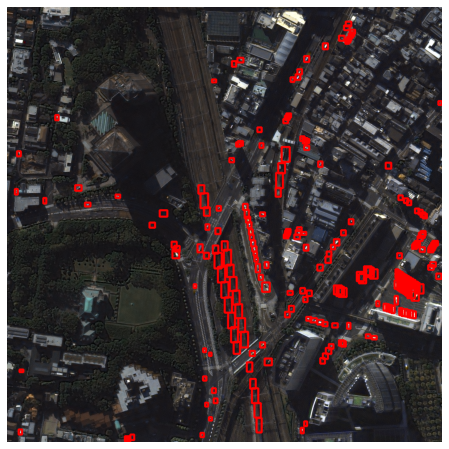

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# 최종학습

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
    
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

RuntimeError: ignored